# Muestreo Centros Digitales

### Cambios en esta versión
* Validar retricción de no más de 20 satelitales por hora

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date
import datetime
import random

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Parámetro para definir el medio de carga de datos

In [4]:
formas_de_ingreso=['db','archivos']
modoIngresoInformacion=formas_de_ingreso[1] #cambia a 1 si se usan archivos

In [5]:
con_graficas=True

## Lectura Bases de datos

In [6]:
if modoIngresoInformacion== 'db':
    ## Llamado funcion para consulta y parametros
    from get_data_from_db import *    
    registros, aps_operativos, num_aps, num_muestras_hora=GetDataFromDB()
    str_list=["ID","BANDA","SUBIDA_LIM","BAJADA_LIM","FECHA","HORA","CONDICION","VELOCIDAD_BAJADA","VELOCIDAD_SUBIDA","CUMPLE_BANDA","CUMPLE_SUBIDA","CUMPLE_BAJADA",'BASE']
    Data=pd.DataFrame.from_records(registros, columns=str_list)
    #Carga Archivos Prueba
    #Data = pd.read_csv(f'query1-Muestras.csv', sep=';')
    num_aps=Data['ID'].nunique()
    num_muestras_hora=int(num_aps*0.1)+1
    print(num_aps,num_muestras_hora)

## Lectura Archivos
###### Codigo para realizar el proceso con lectura de archivos

In [7]:
if modoIngresoInformacion== 'archivos':
    #DataAnterior = pd.read_csv(f'DATA_ACUMULADA.csv', sep=';')
    DataAnterior = pd.read_csv(f'Ejecuciones mensuales - Reporte plano_old.csv',sep=";", decimal=',', encoding='ISO-8859-1')
    DataMesActual = pd.read_csv(f'Ejecuciones mensuales - Reporte plano.csv',sep=";", decimal=',', encoding='ISO-8859-1')
    DataAnteriorB2 =pd.read_csv(f'Analitica Pruebas Adicionales TEST_STDB_old.csv',sep=";", decimal=',', encoding='ISO-8859-1')
    DataMesActualB2 =pd.read_csv(f'Analitica Pruebas Adicionales TEST_STDB.csv',sep=";", decimal=',', encoding='ISO-8859-1')
    
    DataMesActual['BASE']='principal'
    DataAnterior['BASE']='principal'
    DataMesActualB2['BASE']='adicional'
    DataAnteriorB2['BASE']='adicional'
    
    centrosA1=pd.read_csv(f'CLASE_CENTROS.csv',sep=";")
    centrosA1=centrosA1[centrosA1['TIPO']=='1A']
    centrosA1.drop(columns=['ID'], inplace=True)
    #DataAnterior['FECHA']=pd.to_datetime(DataAnterior['FECHA'],dayfirst=True)#valores por defecto    
    Data=DataAnterior.append(DataMesActual)
    ## Validar resultados oficiales
    Data=Data.append(DataAnteriorB2)
    Data=Data.append(DataMesActualB2)
    
    columnasSeleccionadas=[ 'ID Beneficiario','Perfil Ancho de banda', 'Kbps de Subida','Kbps de Bajada','Fecha de la prueba','Hora de la prueba','Condición Encontrada',
                           'Velocidad Efectiva (Download)','Velocidad Efectiva (Upload)','Cumple Ancho de Banda', 'Cumple BW de Bajada','Cumple BW de Subida','BASE']
    Data=Data[columnasSeleccionadas]
    Data.columns=["ID","BANDA","SUBIDA_LIM","BAJADA_LIM","FECHA","HORA","CONDICION","VELOCIDAD_BAJADA","VELOCIDAD_SUBIDA","CUMPLE_BANDA","CUMPLE_SUBIDA","CUMPLE_BAJADA",'BASE']
    #Data=DataAnterior.append(DataMesActual)
    Data=Data.merge(centrosA1[['ID BENEFICIARIO','ESTADO']], left_on='ID', right_on='ID BENEFICIARIO', how='inner')
    Data.drop(columns=['ID BENEFICIARIO','ESTADO'],inplace=True)
    #parametros de los archivos    
    num_aps=Data['ID'].nunique()
    num_muestras_hora=int(num_aps*0.1)+1

In [8]:
num_horas=15

### Leer Archivo Festivos

In [9]:
ubicacionArchivoFestivos="F:/Workflow/Projects\MinTIC_SpeedTest/ProcessScripts/"
ubicacionArchivoFestivos="" #en caso de no ejecutar en el servidor
diasFestivos=pd.read_csv(f'{ubicacionArchivoFestivos}initialize-general-list-holidays.csv',sep=";")
diasFestivos['fecha']=pd.to_datetime(diasFestivos[['YEAR', 'MONTH', 'DAY']])

### Preprocesamiento

In [10]:
Data['FECHA']=pd.to_datetime(Data['FECHA']).dt.date
Data['FECHA']=pd.to_datetime(Data['FECHA'])
maxFecha=Data['FECHA'].max()
minFecha=maxFecha + datetime.timedelta(days=-14)
minFechaFDS=maxFecha + datetime.timedelta(days=-28)

In [11]:
Data['DIA_S']=Data['FECHA'].dt.dayofweek
Data['FILTRO']=Data['DIA_S'].isin([5,6])
Data['FILTRO']=np.where(Data['DIA_S'].isin([5,6]) , 'fds','hab')
Data['FILTRO']=np.where(Data['FECHA'].isin(diasFestivos['fecha']),'fds',Data['FILTRO'])

In [12]:
Data.drop_duplicates(subset=["ID","BANDA","SUBIDA_LIM","BAJADA_LIM","FECHA","HORA","CONDICION","VELOCIDAD_BAJADA","VELOCIDAD_SUBIDA","CUMPLE_BANDA","CUMPLE_SUBIDA","CUMPLE_BAJADA"],keep='first', inplace=True)
Data=Data[(Data['HORA']>=6)&(Data['HORA']<=20)]
DataTotal=Data.copy()
Data=Data[(Data['FECHA']>=minFecha)&(Data['FECHA']<maxFecha)]

##  Resumenes validación

In [13]:
def pieChart(col):
    A = col.value_counts()
    indices = A.index
    plt.pie(A, labels=indices, autopct="%0.0f %%", colors=['dodgerblue','red'])
    plt.axis("equal")
    plt.show()    

In [14]:
## TORTA 1
Data[Data['BASE']=='principal']['CONDICION'].value_counts()

E    13796
F     3097
Name: CONDICION, dtype: int64

In [15]:
Data[Data['BASE']=='principal']['CONDICION'].value_counts()/len(Data[Data['BASE']=='principal'])

E    0.81667
F    0.18333
Name: CONDICION, dtype: float64

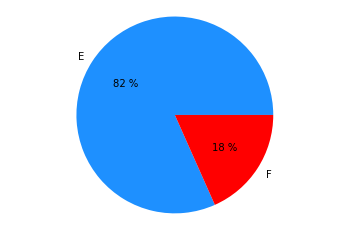

In [16]:
if con_graficas:
    pieChart(Data[Data['BASE']=='principal']['CONDICION'])

In [17]:
DataExito=Data[Data['CONDICION']=='E']

In [18]:
## TORTA 2
DataExito[DataExito['BASE']=='principal']['CUMPLE_BANDA'].value_counts()

SI    12010
NO     1786
Name: CUMPLE_BANDA, dtype: int64

In [19]:
DataExito[DataExito['BASE']=='principal']['CUMPLE_BANDA'].value_counts()/len(DataExito)

SI    0.173698
NO    0.025831
Name: CUMPLE_BANDA, dtype: float64

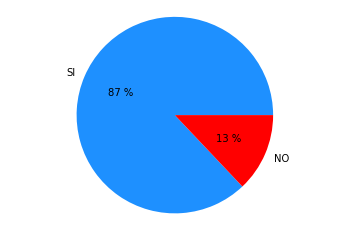

In [20]:
if con_graficas:
    pieChart(DataExito[DataExito['BASE']=='principal']['CUMPLE_BANDA'])

In [21]:
DataExito[DataExito['BASE']=='principal']['CUMPLE_SUBIDA'].value_counts()/len(DataExito[DataExito['BASE']=='principal'])

SI    0.895622
NO    0.104378
Name: CUMPLE_SUBIDA, dtype: float64

In [22]:
DataExito[DataExito['BASE']=='principal']['CUMPLE_BAJADA'].value_counts()/len(DataExito[DataExito['BASE']=='principal'])

SI    0.95448
NO    0.04552
Name: CUMPLE_BAJADA, dtype: float64

In [23]:
#conteo centros con exito
DataExito[DataExito['BASE']=='principal']['ID'].nunique()

688

In [24]:
#conteo centrol críticos
num_aps-DataExito[DataExito['BASE']=='principal']['ID'].nunique()

70

In [25]:
###  GRAFICO

In [26]:
res_hora_cumple_Banda=pd.crosstab(index=DataExito['HORA'],
            columns=DataExito['CUMPLE_BANDA'], margins=True)

In [27]:
res_hora_cumple_Banda['NO']=res_hora_cumple_Banda['NO']/res_hora_cumple_Banda['All']
res_hora_cumple_Banda['SI']=res_hora_cumple_Banda['SI']/res_hora_cumple_Banda['All']

In [28]:
pd.crosstab(index=DataExito['HORA'],
            columns=DataExito['CUMPLE_BANDA'], margins=True, normalize='index')

CUMPLE_BANDA,NO,SI
HORA,,
6,0.142019,0.857981
7,0.147895,0.852105
8,0.154861,0.845139
9,0.154372,0.845628
10,0.159828,0.840172
11,0.161429,0.838571
12,0.164224,0.835776
13,0.171389,0.828611
14,0.168515,0.831485


#### Gráfico

In [29]:
res_grafico=pd.pivot_table(Data[Data['BASE']=='principal'].groupby(['BANDA','HORA','CUMPLE_BANDA'])['ID'].count().reset_index(), index=['BANDA','HORA'],columns=['CUMPLE_BANDA'], values='ID', aggfunc=np.sum, fill_value=0)

In [30]:
res_grafico['TOTAL']=res_grafico.sum(axis=1)

In [31]:
res_grafico['PORCF']=res_grafico['SI']/res_grafico['TOTAL']

In [32]:
res_grafico.reset_index(inplace=True)

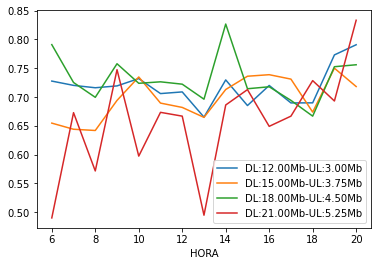

In [33]:
if con_graficas:
    fig, ax = plt.subplots()
    for label, grp in res_grafico.groupby('BANDA'):
        grp.plot(x = 'HORA', y = 'PORCF',ax = ax, label = label)

In [34]:
res_grafico.to_csv('grafica.csv')

In [35]:
def quantiles_adaptados(x):
    conteo=x.count()
    if conteo<=5:
        return x.quantile(0.5)
    elif conteo<=10:
        return x.quantile(0.2)
    else:
        return x.quantile(0.1)

### Archivos de Resumen

In [36]:
today = date.today()
D=today.day
M=today.month
Y=today.year

# Habiles

In [37]:
Data_Habil= Data[(Data['BASE']=='principal')&(Data['FILTRO']=='hab')].groupby(['ID','HORA']).agg(
                CONTEO=('ID','count'),
                SUBIDA=('VELOCIDAD_SUBIDA', quantiles_adaptados),
                BAJADA=('VELOCIDAD_BAJADA', quantiles_adaptados)
            )

In [38]:
Data_Habil.reset_index(inplace=True)
BANDA=Data[['ID','BANDA','SUBIDA_LIM','BAJADA_LIM']].drop_duplicates(subset='ID',keep='last')
Data_Habil=Data_Habil.merge(BANDA,left_on='ID',right_on='ID', how='left')
Data_Habil.rename(columns={'BAJADA_LIM':'BAJA','SUBIDA_LIM':'SUBE','BAJADA':'BAJA_R','SUBIDA':'SUBE_R'}, inplace=True)
Data_Habil=Data_Habil[['ID','BANDA','HORA','BAJA','SUBE','BAJA_R','SUBE_R']]

In [39]:
Data_Habil['CUMPLE_BAJA']=np.where(Data_Habil['BAJA_R']>=Data_Habil['BAJA'],'SI','NO')
Data_Habil['CUMPLE_SUBE']=np.where(Data_Habil['SUBE_R']>=Data_Habil['SUBE'],'SI','NO')
Data_Habil['CUMPLE']=np.where( (Data_Habil['CUMPLE_BAJA']=='SI') & (Data_Habil['CUMPLE_SUBE']=='SI'),'SI','NO')
Data_Habil['PORC_BAJADA']=Data_Habil['BAJA_R']/Data_Habil['BAJA']
Data_Habil['PORC_SUBE']=Data_Habil['SUBE_R']/Data_Habil['SUBE']
Data_Habil['CERCANO_BAJA']=np.where(Data_Habil['PORC_BAJADA']>1, 'CUMPLE', np.where(Data_Habil['PORC_BAJADA']>0.9,'SI','NO'))
Data_Habil['CERCANO_SUBE']=np.where(Data_Habil['PORC_SUBE']>1, 'CUMPLE', np.where(Data_Habil['PORC_SUBE']>0.9,'SI','NO'))
Data_Habil['CERCANO']=np.where( (Data_Habil['CERCANO_BAJA']=='CUMPLE') & (Data_Habil['CERCANO_SUBE']=='CUMPLE'),'CUMPLE',
                                 np.where((Data_Habil['CERCANO_BAJA']=='SI') & (Data_Habil['CERCANO_SUBE']=='SI'),'AMBOS',
                                         np.where((Data_Habil['CERCANO_BAJA']=='CUMPLE') & (Data_Habil['CERCANO_SUBE']=='SI'),'SUBE',
                                                 np.where((Data_Habil['CERCANO_BAJA']=='SI') & (Data_Habil['CERCANO_SUBE']=='CUMPLE'),'BAJA','NO'))))

In [40]:
Data_Habil_Res=Data_Habil.copy()
Data_Habil_Res['TIPO2']=np.where(Data_Habil_Res['CERCANO']=="NO",'NO','SI')
Data_Habil_Res=pd.pivot_table(Data_Habil_Res[['ID','BANDA','CUMPLE']], index=['ID','BANDA'], columns=['CUMPLE'], aggfunc=len, fill_value=0)
Data_Habil_Res['PORC']=Data_Habil_Res['NO']/(Data_Habil_Res['NO']+Data_Habil_Res['SI'])
Data_Habil_Res['TIPO']= np.where(Data_Habil_Res['PORC']==1,'CRITICO',np.where(Data_Habil_Res['PORC']==0,'BUENO','REGULAR'))

In [41]:
if con_graficas:
    Data_Habil.head(14).style.set_table_styles([{
        'selector':'th', 'props':[('background-color','#c00000'),('color','white')]
    }])

In [42]:
### Guardar Achivos
Data_Habil.to_csv('RESUMEN_CENTROS_HORA_'+str(Y*10000+M*100+D)+'_HABIL.csv',sep=';', index=False)
Data_Habil_Res.to_csv('RESUMEN_CENTROS_'+str(Y*10000+M*100+D)+'_HABIL.csv',sep=';', index=False)

### FDS

In [43]:
Data_fds= DataTotal[(DataTotal['BASE']=='principal')&(DataTotal['FILTRO']=='fds')&(DataTotal['FECHA']>=minFechaFDS)&(DataTotal['FECHA']<maxFecha)].groupby(['ID','HORA']).agg(
                CONTEO=('ID','count'),
                SUBIDA=('VELOCIDAD_SUBIDA', quantiles_adaptados),
                BAJADA=('VELOCIDAD_BAJADA', quantiles_adaptados)
            )

In [44]:
Data_fds.reset_index(inplace=True)
BANDA=Data[['ID','BANDA','SUBIDA_LIM','BAJADA_LIM']].drop_duplicates(subset='ID',keep='last')
Data_fds=Data_fds.merge(BANDA,left_on='ID',right_on='ID', how='left')
Data_fds.rename(columns={'BAJADA_LIM':'BAJA','SUBIDA_LIM':'SUBE','BAJADA':'BAJA_R','SUBIDA':'SUBE_R'}, inplace=True)
Data_fds=Data_fds[['ID','BANDA','HORA','BAJA','SUBE','BAJA_R','SUBE_R']]

In [45]:
Data_fds['CUMPLE_BAJA']=np.where(Data_fds['BAJA_R']>=Data_fds['BAJA'],'SI','NO')
Data_fds['CUMPLE_SUBE']=np.where(Data_fds['SUBE_R']>=Data_fds['SUBE'],'SI','NO')
Data_fds['CUMPLE']=np.where( (Data_fds['CUMPLE_BAJA']=='SI') & (Data_fds['CUMPLE_SUBE']=='SI'),'SI','NO')
Data_fds['PORC_BAJADA']=Data_fds['BAJA_R']/Data_fds['BAJA']
Data_fds['PORC_SUBE']=Data_fds['SUBE_R']/Data_fds['SUBE']
Data_fds['CERCANO_BAJA']=np.where(Data_fds['PORC_BAJADA']>1, 'CUMPLE', np.where(Data_fds['PORC_BAJADA']>0.9,'SI','NO'))
Data_fds['CERCANO_SUBE']=np.where(Data_fds['PORC_SUBE']>1, 'CUMPLE', np.where(Data_fds['PORC_SUBE']>0.9,'SI','NO'))
Data_fds['CERCANO']=np.where( (Data_fds['CERCANO_BAJA']=='CUMPLE') & (Data_fds['CERCANO_SUBE']=='CUMPLE'),'CUMPLE',
                                 np.where((Data_fds['CERCANO_BAJA']=='SI') & (Data_fds['CERCANO_SUBE']=='SI'),'AMBOS',
                                         np.where((Data_fds['CERCANO_BAJA']=='CUMPLE') & (Data_fds['CERCANO_SUBE']=='SI'),'SUBE',
                                                 np.where((Data_fds['CERCANO_BAJA']=='SI') & (Data_fds['CERCANO_SUBE']=='CUMPLE'),'BAJA','NO'))))

In [46]:
Data_fds_Res=Data_fds.copy()
Data_fds_Res['TIPO2']=np.where(Data_fds_Res['CERCANO']=="NO",'NO','SI')
Data_fds_Res=pd.pivot_table(Data_fds_Res[['ID','BANDA','CUMPLE']], index=['ID','BANDA'], columns=['CUMPLE'], aggfunc=len, fill_value=0)
Data_fds_Res['PORC']=Data_fds_Res['NO']/(Data_fds_Res['NO']+Data_fds_Res['SI'])
Data_fds_Res['TIPO']= np.where(Data_fds_Res['PORC']==1,'CRITICO',np.where(Data_fds_Res['PORC']==0,'BUENO','REGULAR'))

In [47]:
Data_fds.to_csv('RESUMEN_CENTROS_HORA_'+str(Y*10000+M*100+D)+'_FDS.csv',sep=';',index=False)
Data_fds_Res.to_csv('RESUMEN_CENTROS_'+str(Y*10000+M*100+D)+'_FDS.csv',sep=';',index=False)

# Maestro Aps

In [48]:
maestro_Aps=Data[['ID','BANDA']].drop_duplicates()

#  NUEVA PROPUESTA

## Funcion Asignacion

In [49]:
def asignarMuestras(Data,num_muestras_hora):
    DataExito=Data[Data['CONDICION']=='E']    
    #preprocesamiento
    DataExito['IND']=((DataExito['VELOCIDAD_SUBIDA']-DataExito['SUBIDA_LIM'])+(DataExito['VELOCIDAD_BAJADA']-DataExito['BAJADA_LIM']))/2
    ##DataExito['IND']=((DataExito['VELOCIDAD_SUBIDA']-DataExito['SUBIDA_LIM'])+9*(DataExito['VELOCIDAD_BAJADA']-DataExito['BAJADA_LIM']))/10
    ##DataExito['IND']=((DataExito['VELOCIDAD_SUBIDA']-DataExito['SUBIDA_LIM'])**3+9*(DataExito['VELOCIDAD_BAJADA']-DataExito['BAJADA_LIM'])**3)/10
    
    tabla_ind=DataExito.groupby(['ID','HORA'])[['IND']].median()
    tabla_ind.reset_index(inplace=True)
    tabla_freq=DataExito.groupby(['ID','HORA'])[['CONDICION']].count().reset_index()

    #calculo cumplimiento para mejores y peores casos
    tabla_ind_cump=pd.pivot_table(DataExito[['ID','HORA','CUMPLE_BANDA','CONDICION']], index=['ID','HORA'], columns=['CUMPLE_BANDA'], aggfunc=len, fill_value=0)
    tabla_ind_cump.columns=tabla_ind_cump.columns.droplevel()
    tabla_ind_cump.reset_index(inplace=True)
    tabla_ind_cump['ind_cump']=tabla_ind_cump['SI']/(tabla_ind_cump['SI']+tabla_ind_cump['NO'])
    
    tablaBase=tabla_ind.merge(tabla_freq, left_on=['ID','HORA'], right_on=['ID','HORA'], how='left')
    tablaBase=tablaBase.merge(tabla_ind_cump[['ID','HORA','ind_cump']], left_on=['ID','HORA'], right_on=['ID','HORA'], how='left')
    
    tablaBase.columns=['ID','HORA','IND','FREQ','ind_cump']
    tablaBase.reset_index(inplace=True)

    #Distribución aps bajos
    tablaBase.sort_values(['ID','IND','FREQ'], ascending=False, inplace=True)
    tablaBase.reset_index(drop=True, inplace=True)
    tabla_primera_opcion=tablaBase.groupby(['ID']).nth(0)
    casos_bajos=tabla_primera_opcion[tabla_primera_opcion['IND']<0]
    muestra_bajas_hora=int(len(casos_bajos)/num_horas)+1

    casos_bajos=casos_bajos.sort_values('IND')
    casos_bajos.reset_index(inplace=True)
    casos_bajos.reset_index(inplace=True)
    #casos_bajos
    #lograr la mayor distribución de hora posible
    casos_bajos['franja']=np.where(casos_bajos['level_0']//num_horas%2==0,casos_bajos['level_0']%num_horas,(num_horas-1-casos_bajos['level_0']%num_horas))
    casos_bajos['hora']=casos_bajos['franja']+6
    tablaBase=tablaBase[~tablaBase['ID'].isin(casos_bajos['ID'].unique())]

    num_muestras_hora=num_muestras_hora-muestra_bajas_hora
    asignacionFinal=pd.DataFrame()

    #Asignacion Principal
    i=0
    num_horas_sobre=1
    while num_horas_sobre > 0:   
        #Reordenar la base
        tablaBase.sort_values(['ID','IND','FREQ'], ascending=False, inplace=True)
        tablaBase.reset_index(drop=True, inplace=True)
        tablaBase['index']=tablaBase.index

        tablaBase['dif']=tablaBase.groupby('ID')['IND'].diff(-1)
        tablaBase['index_N']=tablaBase.groupby('ID')['index'].shift(periods=-1)
        tablaBase['HORA_N']=tablaBase.groupby('ID')['HORA'].shift(periods=-1)
        tablaBase['IND_N']=tablaBase.groupby('ID')['IND'].shift(periods=-1)
        tablaBase['FREQ_N']=tablaBase.groupby('ID')['FREQ'].shift(periods=-1)

        tabla_primera_opcion=tablaBase.groupby(['ID']).nth(0)
        tabla_primera_opcion.reset_index(inplace=True)

        tabla_ronda=tabla_primera_opcion

        resumen=tabla_ronda[['HORA']].value_counts().to_frame()
        resumen['DIF']=resumen[0]-num_muestras_hora

        horas_sobre=resumen[resumen['DIF']>0]           
        num_horas_sobre=len(horas_sobre)

        # guardar valores
        if num_horas_sobre>0:
            hora_aux=horas_sobre.index[0][0]
            dif_aux=horas_sobre.iloc[0]['DIF']
            tabla_ronda=tabla_ronda.sort_values('dif')
            saldo=tabla_ronda[tabla_ronda['HORA']==hora_aux][dif_aux:]        
            if i==0:
                asignacionFinal=saldo
            else: 
                asignacionFinal=asignacionFinal.append(saldo)            

            tablaBase=tablaBase[tablaBase['HORA']!=hora_aux]
            tablaBase=tablaBase[~tablaBase['ID'].isin(saldo['ID'])]            
            i+=1

    if i==0:
        asignacionFinal=tabla_ronda
    else: 
        asignacionFinal=asignacionFinal.append(tabla_ronda)


    # Matriz de posiciciones a llenar
    num_muestras_hora=num_muestras_hora+muestra_bajas_hora
    tabla_final=pd.DataFrame({'hora':list(range(6,20+1))},columns=['hora']+list(range(num_muestras_hora)))
    tabla_final.set_index('hora',inplace=True)
    tabla_final['pos']=0

    # Asignar resultado anterior
    for index, row in asignacionFinal.iterrows():    
        hora_aux=int(row['HORA'])
        pos=tabla_final.at[hora_aux,'pos']    
        tabla_final.at[hora_aux,pos]=int(row['ID'])    
        tabla_final.at[hora_aux,'pos']=tabla_final.at[hora_aux,'pos']+1
    
    #Validar aps unicos
    ##print(tabla_final.reset_index().drop(columns=['pos']).melt(id_vars=['hora'],var_name='muestra',value_name='ID').nunique())
    
    #Asignar casos bajos
    for ind,row in casos_bajos.iterrows():
        t_aux=tabla_final.copy()
        t_aux=t_aux[(t_aux['pos']<num_muestras_hora)]
        sel_hora=row['hora']
        idx=int(row['ID'])
        pos=tabla_final.at[sel_hora,'pos']
        tabla_final.at[sel_hora,pos]=idx    
        tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1
    
    #Validar aps unicos
    ##print(tabla_final.reset_index().drop(columns=['pos']).melt(id_vars=['hora'],var_name='muestra',value_name='ID').nunique())
    
    #Agregar 100% F
    APs_sin_Exito=Data[~Data['ID'].isin(DataExito['ID'].unique())]
    APs_sin_Exito=list(APs_sin_Exito['ID'].unique())
    
    #print("aps sin exito",len(APs_sin_Exito))
    
    for idx in APs_sin_Exito:
        #print("entro",idx)
        t_aux=tabla_final.copy()
        t_aux=t_aux[(t_aux['pos']<num_muestras_hora)]
        #sel_hora=t_aux.sample().index[0]
        t_aux=t_aux.sort_values('pos',ascending=True)
        sel_hora=t_aux.head(1).index[0]
        pos=tabla_final.at[sel_hora,'pos']
        tabla_final.at[sel_hora,pos]=idx    
        tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1
    
    #Validar aps unicos
    ##print(tabla_final.reset_index().drop(columns=['pos']).melt(id_vars=['hora'],var_name='muestra',value_name='ID').nunique())
    
    #Asignar mejores casos
    tablaBase=tabla_ind.merge(tabla_freq, left_on=['ID','HORA'], right_on=['ID','HORA'], how='left')
    tablaBase=tablaBase.merge(tabla_ind_cump[['ID','HORA','ind_cump']], left_on=['ID','HORA'], right_on=['ID','HORA'], how='left')
    tablaBase.columns=['ID','HORA','IND','FREQ','ind_cump']
    tablaBase.reset_index(inplace=True)
    mejores_hora=tablaBase[(tablaBase['IND']==1)&(tablaBase['FREQ']>=3)]
    group_casos_mejora=mejores_hora.groupby('ID')

    i=0
    for g in group_casos_mejora.groups:
        i=i+1
        group = group_casos_mejora.get_group(g)
        val_ids=group['HORA'].values
        t_aux=tabla_final.copy()
        t_aux=t_aux[(t_aux['pos']<num_muestras_hora)&(t_aux.index.isin(val_ids))]
        t_aux= t_aux[~t_aux.isin([g]).any(axis=1)]

        for sel_hora in t_aux.index:
            pos=tabla_final.at[sel_hora,'pos']
            tabla_final.at[sel_hora,pos]=int(g)  
            tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1
    
    #Validar aps unicos
    #print(tabla_final.reset_index().drop(columns=['pos']).melt(id_vars=['hora'],var_name='muestra',value_name='ID').nunique())
    
    #Completar faltantes con mejores casos
    tabla_ind_total=pd.pivot_table(DataExito[['ID','CUMPLE_BANDA','CONDICION']], index=['ID'], columns=['CUMPLE_BANDA'], aggfunc=len, fill_value=0)
    tabla_ind_total.columns=tabla_ind_total.columns.droplevel()
    tabla_ind_total.reset_index(inplace=True)
    tabla_ind_total['ind']=tabla_ind_total['SI']/(tabla_ind_total['SI']+tabla_ind_total['NO'])
    tabla_ind_total=tabla_ind_total.sort_values(['ind','SI'], ascending=False)
    pos_mejores=0

    while len(tabla_final[tabla_final['pos']<num_muestras_hora])>0:
        t_aux=tabla_final[tabla_final['pos']<num_muestras_hora]
        id_aux=tabla_ind_total['ID'].values[pos_mejores]
        t_aux= t_aux[~t_aux.isin([id_aux]).any(axis=1)]

        for sel_hora in t_aux.index:
            pos=tabla_final.at[sel_hora,'pos']
            tabla_final.at[sel_hora,pos]=int(id_aux)  
            tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1
        pos_mejores=pos_mejores+1

    ## validar duplicados por hora
    for hora,row in tabla_final.iterrows():    
        a_set = set(row)
        contains_duplicates = len(row) != len(a_set)
        print(hora,contains_duplicates)
    
    #Validar aps unicos
    #print(tabla_final.reset_index().drop(columns=['pos']).melt(id_vars=['hora'],var_name='muestra',value_name='ID').nunique())
    
    #Alistamiento de salida
    tabla_ind_total['tipo']=np.where(tabla_ind_total['ind']==0, 'CRITICO', np.where(tabla_ind_total['ind']==1,'BUENO','REGULAR'))
    tabla_final_un=tabla_final.reset_index().drop(columns=['pos']).melt(id_vars=['hora'],var_name='muestra',value_name='ID')
    tabla_final_un=tabla_final_un.merge(tabla_ind_total, left_on='ID', right_on='ID', how='left')
    tabla_final_un['tipo']=np.where(tabla_final_un['tipo'].isnull(),'CRITICO',tabla_final_un['tipo'])
    tabla_final_un=tabla_final_un.merge(maestro_Aps, left_on='ID', right_on='ID', how='left')
    
    #fin de la funcion,  retorno
    return tabla_final_un

###  Distribucion de las muestras en las bandas

In [50]:
distribucion=Data[['ID','BANDA']].drop_duplicates()

In [51]:
res_dist=distribucion['BANDA'].value_counts().to_frame()
res_dist

,BANDA
DL:12.00Mb-UL:3.00Mb,389
DL:15.00Mb-UL:3.75Mb,199
DL:18.00Mb-UL:4.50Mb,119
DL:21.00Mb-UL:5.25Mb,51


In [52]:
res_dist['tamMuestra']=distribucion['BANDA'].value_counts()*0.1
res_dist

,BANDA,tamMuestra
DL:12.00Mb-UL:3.00Mb,389,38.9
DL:15.00Mb-UL:3.75Mb,199,19.9
DL:18.00Mb-UL:4.50Mb,119,11.9
DL:21.00Mb-UL:5.25Mb,51,5.1


In [53]:
res_dist['tamMuestra_int']=(res_dist['tamMuestra']+1).astype(int)

In [54]:
res_dist['tamMuestra_int'].sum()

77

In [55]:
res_dist.head(1).index[0]

'DL:12.00Mb-UL:3.00Mb'

In [56]:
## Ajustar tamaño
res_dist.at[res_dist.head(1).index,'tamMuestra_int']=res_dist.at[res_dist.head(1).index[0],'tamMuestra_int']+(num_muestras_hora-res_dist['tamMuestra_int'].sum())

In [57]:
res_dist['tamMuestra_int'].sum()

76

In [58]:
res_dist.reset_index(inplace=True)
res_dist

,index,BANDA,tamMuestra,tamMuestra_int
0,DL:12.00Mb-UL:3.00Mb,389,38.9,38
1,DL:15.00Mb-UL:3.75Mb,199,19.9,20
2,DL:18.00Mb-UL:4.50Mb,119,11.9,12
3,DL:21.00Mb-UL:5.25Mb,51,5.1,6


In [59]:
res_dist['minimo']=res_dist['BANDA']/15
res_dist

,index,BANDA,tamMuestra,tamMuestra_int,minimo
0,DL:12.00Mb-UL:3.00Mb,389,38.9,38,25.933333
1,DL:15.00Mb-UL:3.75Mb,199,19.9,20,13.266667
2,DL:18.00Mb-UL:4.50Mb,119,11.9,12,7.933333
3,DL:21.00Mb-UL:5.25Mb,51,5.1,6,3.400000


In [60]:
#res_dist['tamMuestra_int']=[26,20,12,18]

### Habiles

In [61]:
tabla_fina_com=pd.DataFrame()
i=0
for key,row in res_dist.iterrows():
    print(row['index'])
    tabla_final_un=asignarMuestras(Data[(Data['FILTRO']=='hab')&(Data['BANDA']==row['index'])],row['tamMuestra_int'])
    if i==0:
        tabla_fina_com=tabla_final_un.copy()
    else :
        tabla_fina_com=tabla_fina_com.append(tabla_final_un)     
    i=i+1

DL:12.00Mb-UL:3.00Mb
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
DL:15.00Mb-UL:3.75Mb
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
DL:18.00Mb-UL:4.50Mb
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
DL:21.00Mb-UL:5.25Mb
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False


In [62]:
pd.crosstab(index=tabla_fina_com['hora'],
            columns=tabla_fina_com['tipo'], margins=True)

tipo,BUENO,CRITICO,REGULAR,All
hora,,,,
6,8,5,63,76
7,15,6,55,76
8,29,6,41,76
9,39,6,31,76
10,36,6,34,76
11,38,12,26,76
12,48,3,25,76
13,41,13,22,76
14,47,13,16,76


In [63]:
archivo=tabla_fina_com[['ID','BANDA','hora']]
archivo.columns=['ID','BANDA','HORA']
archivo=archivo.sort_values('HORA')

In [64]:
archivo.isnull().sum()

ID       0
BANDA    0
HORA     0
dtype: int64

In [65]:
duplicateRowsDF = archivo[archivo.duplicated()]
duplicateRowsDF

,ID,BANDA,HORA


In [66]:
archivo.to_csv('initialize-general-list-hab.csv',sep=';', index=False)

In [67]:
final_hab=archivo.copy()

In [68]:
final_hab['ID'].nunique()

758

In [69]:
res_dist

,index,BANDA,tamMuestra,tamMuestra_int,minimo
0,DL:12.00Mb-UL:3.00Mb,389,38.9,38,25.933333
1,DL:15.00Mb-UL:3.75Mb,199,19.9,20,13.266667
2,DL:18.00Mb-UL:4.50Mb,119,11.9,12,7.933333
3,DL:21.00Mb-UL:5.25Mb,51,5.1,6,3.400000


In [70]:
final_hab.groupby('BANDA')['ID'].nunique()

BANDA
DL:12.00Mb-UL:3.00Mb    389
DL:15.00Mb-UL:3.75Mb    199
DL:18.00Mb-UL:4.50Mb    119
DL:21.00Mb-UL:5.25Mb     51
Name: ID, dtype: int64

 ### Festivos

In [71]:
tabla_fina_com=pd.DataFrame()
i=0
for key,row in res_dist.iterrows():
    print(row['index'])
    tabla_final_un=asignarMuestras(Data[(Data['FILTRO']=='fds')&(Data['BANDA']==row['index'])],row['tamMuestra_int'])
    if i==0:
        tabla_fina_com=tabla_final_un.copy()
    else :
        tabla_fina_com=tabla_fina_com.append(tabla_final_un)     
    i=i+1

DL:12.00Mb-UL:3.00Mb
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
DL:15.00Mb-UL:3.75Mb
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
DL:18.00Mb-UL:4.50Mb
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
DL:21.00Mb-UL:5.25Mb
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False


In [72]:
pd.crosstab(index=tabla_fina_com['hora'],
            columns=tabla_fina_com['tipo'], margins=True)

tipo,BUENO,CRITICO,REGULAR,All
hora,,,,
6,12,8,56,76
7,23,7,46,76
8,39,7,30,76
9,39,11,26,76
10,52,6,18,76
11,34,5,37,76
12,54,4,18,76
13,45,9,22,76
14,49,11,16,76


In [73]:
archivo=tabla_fina_com[['ID','BANDA','hora']]
archivo.columns=['ID','BANDA','HORA']
archivo=archivo.sort_values('HORA')

In [74]:
archivo.isnull().sum()

ID       0
BANDA    0
HORA     0
dtype: int64

In [75]:
duplicateRowsDF = archivo[archivo.duplicated()]
duplicateRowsDF

,ID,BANDA,HORA


In [76]:
archivo.to_csv('initialize-general-list-fds.csv',sep=';', index=False)

In [77]:
final_fds=archivo.copy()

In [78]:
final_fds['ID'].nunique()

758

In [79]:
final_hab.groupby('BANDA')['ID'].nunique()

BANDA
DL:12.00Mb-UL:3.00Mb    389
DL:15.00Mb-UL:3.75Mb    199
DL:18.00Mb-UL:4.50Mb    119
DL:21.00Mb-UL:5.25Mb     51
Name: ID, dtype: int64

# Prueba Aleatoria
* Realizar asignacion aleatoria
* validar indicadores principales
* calcular número de franjas cumplidas en los 2 escenarios

In [80]:
APs_id=DataTotal['ID'].unique()
len(APs_id)

758

In [81]:
#num_muestras_hora=num_muestras_hora+muestra_bajas_hora
tabla_final=pd.DataFrame({'hora':list(range(6,20+1))},columns=['hora']+list(range(num_muestras_hora)))
tabla_final.set_index('hora',inplace=True)
tabla_final['pos']=0

## Asignación al azar  1

* Todos los Aps una hora

In [82]:
for aps in APs_id:
    pos=76
    while pos>=76:
        sel_hora=random.randint(6, num_horas+5)
        pos=tabla_final.at[sel_hora,'pos']
        #print(hora_rand)
    
    tabla_final.at[sel_hora,pos]=aps    
    tabla_final.at[sel_hora,'pos']=tabla_final.at[sel_hora,'pos']+1

In [83]:
tabla_final['pos'].sum()

758

###  Completar faltantes con APs al azar

In [84]:
for hora_i in range(6,21):
    print(hora_i)
    pos=tabla_final.at[hora_i,'pos']
    for muestra_i in range(pos,76):
        aps_aux=random.choice(APs_id)
        tabla_final.at[hora_i,muestra_i]=aps_aux
        tabla_final.at[hora_i,'pos']=tabla_final.at[hora_i,'pos']+1
    

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [85]:
tabla_final.reset_index().drop(columns=['pos']).melt(id_vars=['hora'],var_name='muestra',value_name='ID')

,hora,muestra,ID
0,6,0,14715
1,7,0,20022
2,8,0,13774
3,9,0,13258
4,10,0,11188
...,...,...,...
1135,16,75,31726
1136,17,75,20762
1137,18,75,13445
1138,19,75,47804


In [86]:
final_aleatorio=tabla_final.reset_index().drop(columns=['pos']).melt(id_vars=['hora'],var_name='muestra',value_name='ID')

## Comparacion Resultados

### Union con muestreos

In [87]:
DataTotal_validacion=DataTotal.copy()

In [88]:
final_aleatorio.rename(columns={'ID':'ID_aleatorio'})

,hora,muestra,ID_aleatorio
0,6,0,14715
1,7,0,20022
2,8,0,13774
3,9,0,13258
4,10,0,11188
...,...,...,...
1135,16,75,31726
1136,17,75,20762
1137,18,75,13445
1138,19,75,47804


In [89]:
DataTotal_validacion=DataTotal_validacion.merge(final_aleatorio.rename(columns={'ID':'ID_aleatorio'}), left_on=['HORA','ID'], right_on=['hora','ID_aleatorio'],how='left')

In [90]:
DataTotal_validacion=DataTotal_validacion.merge(final_fds.rename(columns={'ID':'ID_fds'}), left_on=['HORA','ID'], right_on=['HORA','ID_fds'],how='left')

In [91]:
DataTotal_validacion=DataTotal_validacion.merge(final_hab.rename(columns={'ID':'ID_hab'}), left_on=['HORA','ID'], right_on=['HORA','ID_hab'],how='left')

In [92]:
DataTotal_validacion[DataTotal_validacion['ID_hab'].notnull()]

,ID,BANDA_x,SUBIDA_LIM,BAJADA_LIM,FECHA,HORA,CONDICION,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,CUMPLE_BANDA,...,BASE,DIA_S,FILTRO,hora,muestra,ID_aleatorio,ID_fds,BANDA_y,ID_hab,BANDA
9,10835,DL:18.00Mb-UL:4.50Mb,4500,18000,2021-11-05,11,E,15642.22,2391.37,NO,...,principal,4,hab,NaN,NaN,NaN,NaN,NaN,10835,DL:18.00Mb-UL:4.50Mb
37,10835,DL:18.00Mb-UL:4.50Mb,4500,18000,2021-12-04,11,E,15843.65,2802.53,NO,...,principal,5,fds,NaN,NaN,NaN,NaN,NaN,10835,DL:18.00Mb-UL:4.50Mb
38,10835,DL:18.00Mb-UL:4.50Mb,4500,18000,2021-12-05,11,E,16082.88,3758.71,NO,...,principal,6,fds,NaN,NaN,NaN,NaN,NaN,10835,DL:18.00Mb-UL:4.50Mb
49,10835,DL:18.00Mb-UL:4.50Mb,4500,18000,2021-12-15,11,F,-1.00,-1.00,NO,...,principal,2,hab,NaN,NaN,NaN,NaN,NaN,10835,DL:18.00Mb-UL:4.50Mb
65,10835,DL:18.00Mb-UL:4.50Mb,4500,18000,2021-11-24,11,E,15703.72,3614.81,NO,...,adicional,2,hab,NaN,NaN,NaN,NaN,NaN,10835,DL:18.00Mb-UL:4.50Mb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211117,74367,DL:12.00Mb-UL:3.00Mb,3000,12000,2021-12-12,10,E,16462.95,7725.01,SI,...,adicional,6,fds,NaN,NaN,NaN,NaN,NaN,74367,DL:12.00Mb-UL:3.00Mb
211125,74367,DL:12.00Mb-UL:3.00Mb,3000,12000,2021-12-13,10,E,16110.40,7646.35,SI,...,adicional,0,hab,NaN,NaN,NaN,NaN,NaN,74367,DL:12.00Mb-UL:3.00Mb
211140,74367,DL:12.00Mb-UL:3.00Mb,3000,12000,2021-12-15,10,E,16377.70,7696.12,SI,...,adicional,2,hab,NaN,NaN,NaN,NaN,NaN,74367,DL:12.00Mb-UL:3.00Mb
211155,74367,DL:12.00Mb-UL:3.00Mb,3000,12000,2021-12-17,10,E,16399.90,7600.70,SI,...,adicional,4,hab,NaN,NaN,NaN,NaN,NaN,74367,DL:12.00Mb-UL:3.00Mb


In [93]:
DataTotal_validacion['ID_analitica']=np.where(DataTotal_validacion['FILTRO']=='hab',DataTotal_validacion['ID_hab'],DataTotal_validacion['ID_fds'])

### Resumen indicadores
*  No se paga por esta medida

In [94]:
Resultados_aleatorio=DataTotal_validacion[(DataTotal_validacion['ID_aleatorio'].notnull())]

In [95]:
Resultados_analitica=DataTotal_validacion[(DataTotal_validacion['ID_analitica'].notnull())]

In [96]:
Resultados_aleatorio['ID_aleatorio'].nunique()

758

In [97]:
Resultados_aleatorio

,ID,BANDA_x,SUBIDA_LIM,BAJADA_LIM,FECHA,HORA,CONDICION,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,CUMPLE_BANDA,...,DIA_S,FILTRO,hora,muestra,ID_aleatorio,ID_fds,BANDA_y,ID_hab,BANDA,ID_analitica
47,10835,DL:18.00Mb-UL:4.50Mb,4500,18000,2021-12-13,13,F,-1.00,-1.00,NO,...,0,hab,13.0,0,10835,NaN,NaN,NaN,NaN,NaN
51,10835,DL:18.00Mb-UL:4.50Mb,4500,18000,2021-12-17,13,F,-1.00,-1.00,NO,...,4,hab,13.0,0,10835,NaN,NaN,NaN,NaN,NaN
66,10835,DL:18.00Mb-UL:4.50Mb,4500,18000,2021-11-24,13,E,15958.25,3199.28,NO,...,2,hab,13.0,0,10835,NaN,NaN,NaN,NaN,NaN
73,10835,DL:18.00Mb-UL:4.50Mb,4500,18000,2021-11-25,13,E,15765.46,3358.59,NO,...,3,hab,13.0,0,10835,NaN,NaN,NaN,NaN,NaN
88,10835,DL:18.00Mb-UL:4.50Mb,4500,18000,2021-11-27,13,E,16093.66,3246.50,NO,...,5,fds,13.0,0,10835,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211083,74367,DL:12.00Mb-UL:3.00Mb,3000,12000,2021-12-07,15,E,16275.28,7521.46,SI,...,1,hab,15.0,49,74367,74367,DL:12.00Mb-UL:3.00Mb,NaN,NaN,NaN
211098,74367,DL:12.00Mb-UL:3.00Mb,3000,12000,2021-12-09,15,E,16338.16,7717.44,SI,...,3,hab,15.0,49,74367,74367,DL:12.00Mb-UL:3.00Mb,NaN,NaN,NaN
211112,74367,DL:12.00Mb-UL:3.00Mb,3000,12000,2021-12-11,15,E,16452.24,7656.38,SI,...,5,fds,15.0,49,74367,74367,DL:12.00Mb-UL:3.00Mb,NaN,NaN,74367
211135,74367,DL:12.00Mb-UL:3.00Mb,3000,12000,2021-12-14,15,E,16401.85,7708.63,SI,...,1,hab,15.0,49,74367,74367,DL:12.00Mb-UL:3.00Mb,NaN,NaN,NaN


In [98]:
Resultados_aleatorio.groupby('BANDA_x')['ID'].nunique()

BANDA_x
DL:12.00Mb-UL:3.00Mb    389
DL:15.00Mb-UL:3.75Mb    199
DL:18.00Mb-UL:4.50Mb    119
DL:21.00Mb-UL:5.25Mb     51
Name: ID, dtype: int64

In [99]:
Resultados_analitica['ID_analitica'].nunique()

758

#### EXITO / FRACASO

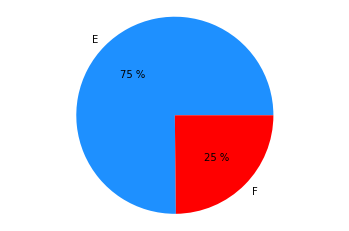

In [100]:
if con_graficas:
    pieChart(Resultados_aleatorio['CONDICION'])

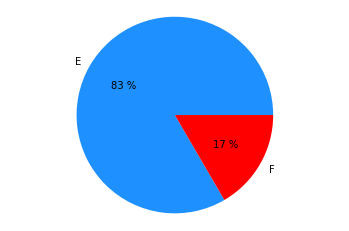

In [101]:
if con_graficas:
    pieChart(Resultados_analitica['CONDICION'])

#### CUMPLE BANDA

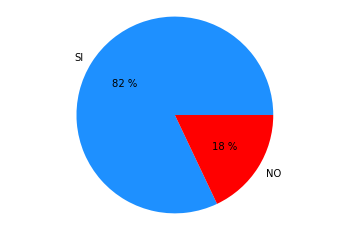

In [102]:
if con_graficas:
    pieChart(Resultados_aleatorio[Resultados_aleatorio['CONDICION']=='E']['CUMPLE_BANDA'])

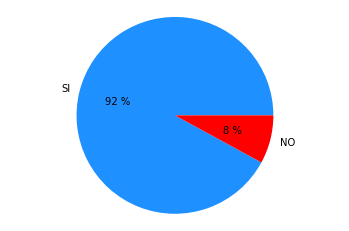

In [103]:
if con_graficas:
    pieChart(Resultados_analitica[Resultados_analitica['CONDICION']=='E']['CUMPLE_BANDA'])

### Subida

In [104]:
Resultados_aleatorio[Resultados_aleatorio['CONDICION']=='E']['CUMPLE_SUBIDA'].value_counts()/len(Resultados_aleatorio[Resultados_aleatorio['CONDICION']=='E'])

SI    0.857368
NO    0.142632
Name: CUMPLE_SUBIDA, dtype: float64

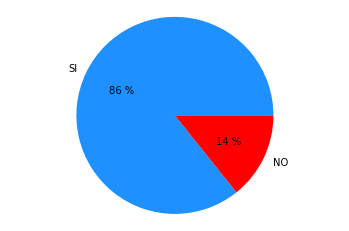

In [105]:
if con_graficas:
    pieChart(Resultados_aleatorio[Resultados_aleatorio['CONDICION']=='E']['CUMPLE_SUBIDA'])

In [106]:
Resultados_analitica[Resultados_analitica['CONDICION']=='E']['CUMPLE_SUBIDA'].value_counts()/len(Resultados_analitica[Resultados_analitica['CONDICION']=='E'])

SI    0.937453
NO    0.062547
Name: CUMPLE_SUBIDA, dtype: float64

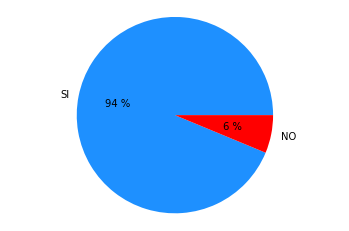

In [107]:
if con_graficas:
    pieChart(Resultados_analitica[Resultados_analitica['CONDICION']=='E']['CUMPLE_SUBIDA'])

## Bajada

In [108]:
Resultados_aleatorio[Resultados_aleatorio['CONDICION']=='E']['CUMPLE_BAJADA'].value_counts()/len(Resultados_aleatorio[Resultados_aleatorio['CONDICION']=='E'])

SI    0.935024
NO    0.064976
Name: CUMPLE_BAJADA, dtype: float64

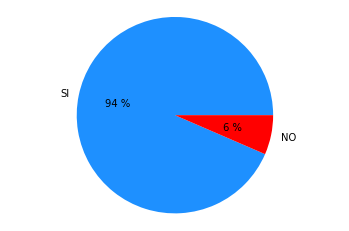

In [109]:
if con_graficas:
    pieChart(Resultados_aleatorio[Resultados_aleatorio['CONDICION']=='E']['CUMPLE_BAJADA'])

In [110]:
Resultados_analitica[Resultados_analitica['CONDICION']=='E']['CUMPLE_BAJADA'].value_counts()/len(Resultados_analitica[Resultados_analitica['CONDICION']=='E'])

SI    0.972025
NO    0.027975
Name: CUMPLE_BAJADA, dtype: float64

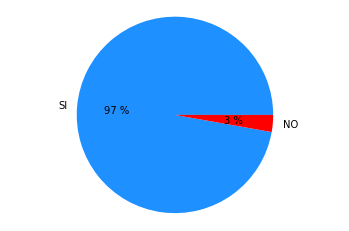

In [111]:
if con_graficas:
    pieChart(Resultados_analitica[Resultados_analitica['CONDICION']=='E']['CUMPLE_BAJADA'])

In [112]:
Resultados_aleatorio['BASE'].value_counts()/len(Resultados_aleatorio)

adicional    0.719082
principal    0.280918
Name: BASE, dtype: float64

In [113]:
Resultados_analitica['BASE'].value_counts()/len(Resultados_analitica)

adicional    0.584738
principal    0.415262
Name: BASE, dtype: float64

## Cumplimiento Franjas

In [114]:
dic_cumplimiento={'DL:12.00Mb-UL:3.00Mb':[12000,3000],'DL:15.00Mb-UL:3.75Mb':[15000,3750],'DL:18.00Mb-UL:4.50Mb':[18000,4500],'DL:21.00Mb-UL:5.25Mb':[21000,5250]}
dic_cumplimiento=pd.DataFrame.from_dict(dic_cumplimiento, orient='index')
dic_cumplimiento.columns=['Lim_bajada','Lim_subida']
dic_cumplimiento

,Lim_bajada,Lim_subida
DL:12.00Mb-UL:3.00Mb,12000,3000
DL:15.00Mb-UL:3.75Mb,15000,3750
DL:18.00Mb-UL:4.50Mb,18000,4500
DL:21.00Mb-UL:5.25Mb,21000,5250


In [115]:
Resultados_aleatorio.columns

Index(['ID', 'BANDA_x', 'SUBIDA_LIM', 'BAJADA_LIM', 'FECHA', 'HORA',
       'CONDICION', 'VELOCIDAD_BAJADA', 'VELOCIDAD_SUBIDA', 'CUMPLE_BANDA',
       'CUMPLE_SUBIDA', 'CUMPLE_BAJADA', 'BASE', 'DIA_S', 'FILTRO', 'hora',
       'muestra', 'ID_aleatorio', 'ID_fds', 'BANDA_y', 'ID_hab', 'BANDA',
       'ID_analitica'],
      dtype='object')

In [116]:
res_franjas_aleatorio=Resultados_aleatorio[Resultados_aleatorio['CONDICION']=='E'].groupby(['BANDA_x','HORA'])['VELOCIDAD_BAJADA','VELOCIDAD_SUBIDA'].quantile(0.05).reset_index()
res_franjas_aleatorio=res_franjas_aleatorio.merge(dic_cumplimiento,left_on='BANDA_x', right_index=True, how='left')
res_franjas_aleatorio['cump_bajada']=np.where(res_franjas_aleatorio['VELOCIDAD_BAJADA']>=res_franjas_aleatorio['Lim_bajada'],1,0)
res_franjas_aleatorio['cump_subida']=np.where(res_franjas_aleatorio['VELOCIDAD_SUBIDA']>=res_franjas_aleatorio['Lim_subida'],1,0)

In [117]:
res_franjas_aleatorio.groupby('BANDA_x')['cump_bajada','cump_subida'].sum()

,cump_bajada,cump_subida
BANDA_x,,
DL:12.00Mb-UL:3.00Mb,0,9
DL:15.00Mb-UL:3.75Mb,0,4
DL:18.00Mb-UL:4.50Mb,1,7
DL:21.00Mb-UL:5.25Mb,1,6


In [118]:
res_franjas_analitica=Resultados_analitica[Resultados_analitica['CONDICION']=='E'].groupby(['BANDA_x','HORA'])['VELOCIDAD_BAJADA','VELOCIDAD_SUBIDA'].quantile(0.05).reset_index()
res_franjas_analitica=res_franjas_analitica.merge(dic_cumplimiento,left_on='BANDA_x', right_index=True, how='left')
res_franjas_analitica['cump_bajada']=np.where(res_franjas_analitica['VELOCIDAD_BAJADA']>=res_franjas_analitica['Lim_bajada'],1,0)
res_franjas_analitica['cump_subida']=np.where(res_franjas_analitica['VELOCIDAD_SUBIDA']>=res_franjas_analitica['Lim_subida'],1,0)
res_franjas_analitica

,BANDA_x,HORA,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,Lim_bajada,Lim_subida,cump_bajada,cump_subida
0,DL:12.00Mb-UL:3.00Mb,6,9424.7860,2915.8540,12000,3000,0,0
1,DL:12.00Mb-UL:3.00Mb,7,9881.4020,3111.7840,12000,3000,0,1
2,DL:12.00Mb-UL:3.00Mb,8,11661.7950,3703.5025,12000,3000,0,1
3,DL:12.00Mb-UL:3.00Mb,9,13372.7270,3607.1730,12000,3000,1,1
4,DL:12.00Mb-UL:3.00Mb,10,12501.1550,3777.5690,12000,3000,1,1
5,DL:12.00Mb-UL:3.00Mb,11,12828.5155,3728.8480,12000,3000,1,1
6,DL:12.00Mb-UL:3.00Mb,12,13496.0310,3839.6285,12000,3000,1,1
7,DL:12.00Mb-UL:3.00Mb,13,12321.9150,2719.9320,12000,3000,1,0
8,DL:12.00Mb-UL:3.00Mb,14,12674.1200,3689.0100,12000,3000,1,1
9,DL:12.00Mb-UL:3.00Mb,15,13003.3820,3515.2280,12000,3000,1,1


In [119]:
res_franjas_analitica.groupby('BANDA_x')['cump_bajada','cump_subida'].sum()

,cump_bajada,cump_subida
BANDA_x,,
DL:12.00Mb-UL:3.00Mb,10,13
DL:15.00Mb-UL:3.75Mb,3,14
DL:18.00Mb-UL:4.50Mb,7,14
DL:21.00Mb-UL:5.25Mb,2,13
